In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Input, layers
from tensorflow.keras import activations
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as k
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

# ZH - English

## Training set 

In [2]:
# corpus_scor = "C:/Users/pc/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/de-en/scores.csv"
# corpus_path_ref = "C:/Users/pc/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/de-en/laser.reference_embeds.npy"
# corpus_path_source = "C:/Users/pc/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/de-en/laser.source_embeds.npy"
# corpus_path_translation = "C:/Users/pc/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/de-en/laser.translation_embeds.npy"

In [3]:
corpus_scor = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/zh-en/scores.csv"
corpus_path_ref = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/zh-en/laser.reference_embeds.npy"
corpus_path_source = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/zh-en/laser.source_embeds.npy"
corpus_path_translation = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/zh-en/laser.translation_embeds.npy"

In [4]:
corpus_scores = pd.read_csv(corpus_scor)
corpus_reference = np.load(corpus_path_ref, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
corpus_source = np.load(corpus_path_source, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
corpus_translation = np.load(corpus_path_translation, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [5]:
# [h; r; h s; h  r; |h − s|; |h − r|] 

# Dot product Translation + source
h_dot_s = np.dot(corpus_translation,corpus_source.T)

# dot product tranlation reference
h_dot_r = np.dot(corpus_translation,corpus_reference.T)

# Absolute difference translation-source
abs_h_s = np.absolute(corpus_translation - corpus_source)
abs_h_s.shape

# Absolute difference translation-reference
abs_h_r = np.absolute(corpus_translation - corpus_reference)
abs_h_r.shape

train = np.concatenate((corpus_translation,corpus_reference,h_dot_s,h_dot_r,abs_h_s,abs_h_r),axis=1)

little_train = np.concatenate((corpus_translation,corpus_reference,abs_h_r),axis=1)

print(h_dot_s.shape,h_dot_r.shape)
print(abs_h_s.shape,abs_h_r.shape)
print(train.shape,little_train.shape )

(26419, 26419) (26419, 26419)
(26419, 1024) (26419, 1024)
(26419, 56934) (26419, 3072)


In [6]:
test_scor = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/testset/zh-en/scores.csv"
testset_path_ref = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/testset/zh-en/laser.reference_embeds.npy"
testset_path_source = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/testset/zh-en/laser.source_embeds.npy"
testset_path_translation = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/testset/zh-en/laser.translation_embeds.npy"

In [7]:
test_score = pd.read_csv(test_scor)
testset_reference = np.load(testset_path_ref, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
testset_source = np.load(testset_path_source, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
testset_translation = np.load(testset_path_translation, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [8]:
testset_reference.shape

(25352, 1024)

In [9]:
# [h; r; h s; h  r; |h − s|; |h − r|] 

# Dot product Translation + source
h_dot_s = np.dot(testset_translation,testset_source.T)

# dot product tranlation reference
h_dot_r = np.dot(testset_translation,testset_reference.T)

# Absolute difference translation-source
abs_h_s = np.absolute(testset_translation - testset_source)
abs_h_s.shape

# Absolute difference translation-reference
abs_h_r = np.absolute(testset_translation - testset_reference)
abs_h_r.shape

test = np.concatenate((testset_translation,testset_reference,h_dot_s,h_dot_r,abs_h_s,abs_h_r),axis=1)

little_test = np.concatenate((testset_translation,testset_reference,abs_h_r),axis=1)

print(h_dot_s.shape,h_dot_r.shape)
print(abs_h_s.shape,abs_h_r.shape)
print(test.shape,little_test.shape )

(25352, 25352) (25352, 25352)
(25352, 1024) (25352, 1024)
(25352, 54800) (25352, 3072)


# Simple feed forward network

<!-- # LSTM
## Text Classification with RNN - bi-directional 
https://www.tensorflow.org/tutorials/text/text_classification_rnn -->

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [11]:
reference_labels = np.array(corpus_scores['z-score'])
reference_labels.shape

(26419,)

In [12]:
X = little_train
X.shape

(26419, 3072)

In [13]:
Y = reference_labels
Y.shape

(26419,)

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(21135, 3072) (21135,)
(5284, 3072) (5284,)


In [15]:
# # X_train = X_train.reshape(-1,1,1024)
# # X_val = X_val.reshape(-1,1,1024)
# # Y_train = Y_train.reshape(-1,1,1)
# # Y_val = Y_val.reshape(-1,1,1)
# # print(X_train.shape,Y_train.shape)
# # print(X_val.shape,Y_val.shape)

# X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)

# # Y_train=Y_train.reshape(Y_train.shape[0],Y_train.shape[1],1)

# X_val=X_val.reshape(X_val.shape[0],X_val.shape[1],1)

# Y_val=Y_val.reshape(Y_val.shape[0],Y_val.shape[1],1)

# print(X_train.shape,Y_train.shape)
# print(X_val.shape,Y_val.shape)

In [16]:
# Callbacks
batch_size =10248

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.0001,
                              patience=5, min_lr=0.0001)

mcp = ModelCheckpoint('model.h5', 
                      monitor='val_loss', verbose=1, 
                      save_best_only=True, save_weights_only=True)

In [17]:
# model with better results 
model = Sequential()
model.add(Dense(1024, input_shape=(X_train.shape[1],), activation = 'relu'))
# model.add(Dropout(0.1))
model.add(Dense(512, activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation ='relu'))
model.add(Dense(1))

In [18]:
# # Callbacks

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.0001,
#                               patience=5, min_lr=0.00001)

# mcp = ModelCheckpoint('model.h5', 
#                       monitor='val_loss', verbose=0, 
#                       save_best_only=True, save_weights_only=True)

# batch_size = 14336

# model = Sequential()

# model.add(Dense(2048, input_shape=(X_train.shape[1],), activation = 'relu'))
# # model.add(Dropout(0.1))
# model.add(Dense(1024, activation ='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(512, activation ='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(256, activation ='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(128, activation ='relu'))
# model.add(Dense(1))

In [19]:
model.compile(loss=tf.keras.losses.MSE,
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['mae'])

In [20]:
print("Fit model on training data")
history = model.fit(
    X_train,
    Y_train,
    epochs=500, # previous 1000
    batch_size =batch_size,# previous one 8192 #4096 - best score so far
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, Y_val),verbose =0, callbacks=[early_stop,reduce_lr]) # validation_split=0.2,mcp

Fit model on training data


(0.0, 1.5333777353167535)

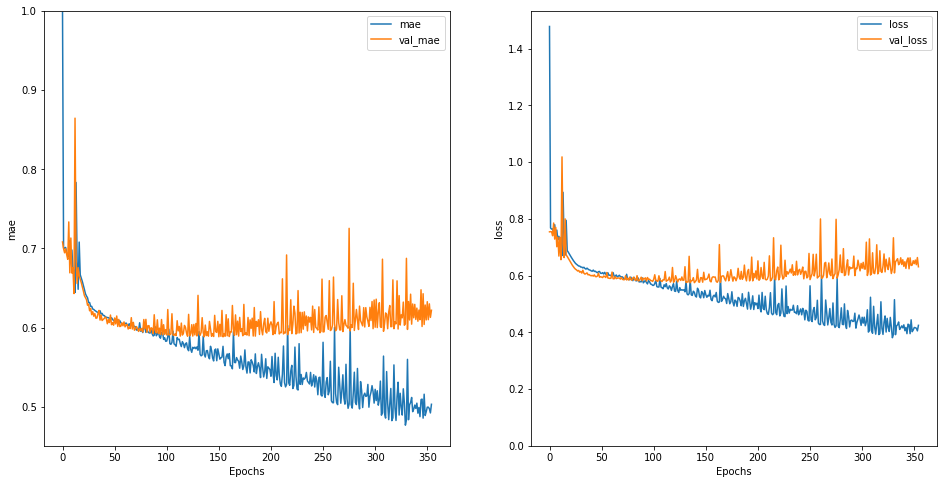

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'mae')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [22]:
# Evaluate the model on the test data using `evaluate`

print("Evaluate on test data")
results = model.evaluate(X_val, Y_val, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 0s 1ms/step - loss: 0.6313 - mae: 0.6219
test loss, test acc: [0.6313040256500244, 0.6219494342803955]


# predicting @ test data

In [23]:
# Generate predictions (probabilities -- the output of the last layer) on new data using `predict`
print("Generate predictions samples")
predictions = model.predict(little_test)
print("predictions shape:", predictions.shape)

Generate predictions samples
predictions shape: (25352, 1)


In [24]:
test_score['lp'] = 'zh-en'
test_score['score'] = predictions
test_score.head()

,source,reference,translation,lp,score
0,已经批准筹建的，暂停批准开业,"Where the preparation has been approved, the a...",Approval of opening on these establishments wi...,zh-en,-0.301454
1,王丰源在首发式发言中说，来美国前想找本书看看别人的经验，但他翻遍新华书店没找到关于留学美国中...,"In his opening speech, Mr. Wang said he wanted...",Wang Fengyuan spoke at the launch of his new b...,zh-en,-0.457278
2,“如果你不致力于创造透明文化，你会失去人才，”维特拉诺说道。,"""if you're not committed to creating a culture...","""If you're not committed to creating a culture...",zh-en,0.888513
3,不过前提是多国联军先停止对也门的袭击。,"The premise, however, is that the coalition fo...","However, the premise is that the multinational...",zh-en,0.394524
4,“在此之前，我和前男友住在骑士桥的一个更大的房子里，”乔安妮说道。,"""before that, my ex and I lived in a bigger ho...","""Before this, I was living with my ex in Knigh...",zh-en,-0.209283


In [25]:
test_score.to_csv('zh-en_predictions.csv')

# checking corr @ X_val

In [26]:
# Generate predictions (probabilities -- the output of the last layer) on new data using `predict`
print("Generate predictions samples")
predictions = model.predict(X_val)
print("predictions shape:", predictions.shape)

Generate predictions samples
predictions shape: (5284, 1)


In [27]:
corr_data = pd.DataFrame([Y_val]).T
pred = pd.DataFrame(predictions)
corr_data['predictions'] = pred
corr_data.columns = ['z-score','predictions']
corr_data.corr()

,z-score,predictions
z-score,1.000000,0.474003
predictions,0.474003,1.000000
